In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import pandas as pd
import glob
from pytz import all_timezones

In [2]:
# Pandas dataframe from pandora data
npz = np.load('PandoraALTZ.npz',allow_pickle=True)
df= pd.DataFrame.from_dict({item: npz[item] for item in npz.files})
npz.close()

In [3]:
# Filtered data by qflag 0,10
options = [0,10] 
rslt_df = df[df['qflag'].isin(options)] 
#localization of dataframe so that datetime is UTC and not naive
dtimeutc=rslt_df.dtime.dt.tz_localize('Etc/UTC')
dtimelocal=dtimeutc.dt.tz_convert('Etc/GMT+6')
dflocal = rslt_df.assign(dtime=dtimelocal)
tslocal = dflocal.set_index('dtime')
### changing dobson units
tsloc_molcm2=tslocal.assign(ozone=tslocal.ozone*2.6868e16)
## grouping by hour
tslocmean = tsloc_molcm2.ozone.groupby(tslocal.index.hour).mean()
tslocstd=tsloc_molcm2.ozone.groupby(tslocal.index.hour).std()
## grouping by month
tslocmeanmt = tsloc_molcm2.ozone.groupby(tslocal.index.month).mean()
tslocstdmt = tsloc_molcm2.ozone.groupby(tslocal.index.month).std()


In [38]:
# Pandas DataFrame from MERRA2 data
# data is stored in folders by year, filenames are O3_YYYY_MM_DD_HH.txt
years = np.arange(2012,2020)
date=[]
O3=[]
#testcount = 0
for year in years:
    merrapath = 'D:\\CCA\\PANDONIA\\O3fromMERRA2\\'+'%i*\\' % (year) + '*.*'
    filelist = glob.glob(merrapath)
    #testcount = testcount + len(filelist)
    #print(testcount)
    for filename in filelist:
        tempdfa = pd.read_csv(filename)
        tempdfa.set_axis(['fixedP','fixedO3','modelP','modelO3'], axis=1, inplace=True)
        columnO3=tempdfa.modelO3.sum()
        time=dt.datetime.strptime(filename[-17:-4],'%Y_%m_%d_%H')
        date.append(time)
        O3.append(columnO3)
merradf2 = pd.DataFrame(data={"date": date, "ozone": O3})


In [33]:
# Pandas DataFrame from MERRA2 data
# data is stored in folders by year, filenames are O3_YYYY_MM_DD_HH.txt
years = np.arange(2012,2020)
date=[]
O3=[]
#testcount = 0
for year in years:
    merrapath = 'D:\\CCA\\PANDONIA\\O3fromMERRA2\\'+'%i*\\' % (year) + '*.*'
    filelist = glob.glob(merrapath)
    #testcount = testcount + len(filelist)
    #print(testcount)
    for filename in filelist:
        tempdf = pd.read_csv(filename)
        tempdf.set_axis(['fixedP','fixedO3','modelP','modelO3'], axis=1, inplace=True)
        
        ############################ converting pressure to altitude
        tdfa = tempdf[tempdf['modelP'] <= 226.32].assign(modelP=((1.73-np.log(tempdf.modelP/226.32))/0.000157))
        tdfb = tempdf[tempdf['modelP'] > 226.32].assign(modelP=((1-(tempdf.modelP/1013.25)**(1/5.25588))/2.25577e-5))
        tempdf2=tdfa.append(tdfb)
        tempdf2.set_axis(['fixedP','fixedO3','modelAlt','modelO3'], axis=1, inplace=True)
        
        ############################ altitude difference series
        altdiff=tempdf2.modelAlt.diff()
        altdiff=altdiff.replace(altdiff[0],altdiff[1])
        altdiff=-altdiff
        
        ############################ converting altitude to T in degC
        tdfa = tempdf2[tempdf2['modelAlt'] <= 11000].assign(modelAlt=(15.04-0.00649*tempdf2.modelAlt))
        tdfb = testdf2[tempdf2['modelAlt'] > 11000].assign(modelAlt=-56.46)
        tempdf3=tdfb.append(tdfa)
        tempdf3.set_axis(['fixedP','fixedO3','modelT','modelO3'], axis=1, inplace=True)
        
        ############################ calculating air number density and ozone number density
        nair = testdf.modelP*100*6.022e23/(8.314463*(testdf3.modelT+273.15))
        testdf4 = testdf2.assign(modelO3=testdf3.modelO3*nair)
        
        ############################ calculating total column density
        columnO3=(testdf4.modelO3*altdiff).sum()/10000
        
        ############################ extracting datetime from filename
        time=dt.datetime.strptime(filename[-17:-4],'%Y_%m_%d_%H')
        date.append(time)
        O3.append(columnO3)
merradf = pd.DataFrame(data={"date": date, "ozone": O3})


In [34]:
tsmerra = merradf.set_index('date')
tsmerrameanmt = tsmerra.ozone.groupby(tsmerra.index.month).mean()
tsmerramm = tsmerra.ozone.resample('M').mean()
tsmerramm2 = tsmerramm.groupby(tsmerramm.index.month).mean()
tsmerrastdmt = tsmerra.ozone.groupby(tsmerra.index.month).std()


C:\Users\muss\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)
C:\Users\muss\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


<AxesSubplot:title={'center':'Ozone yearly profile'}, xlabel='Month', ylabel='molecule/cm$^2$'>

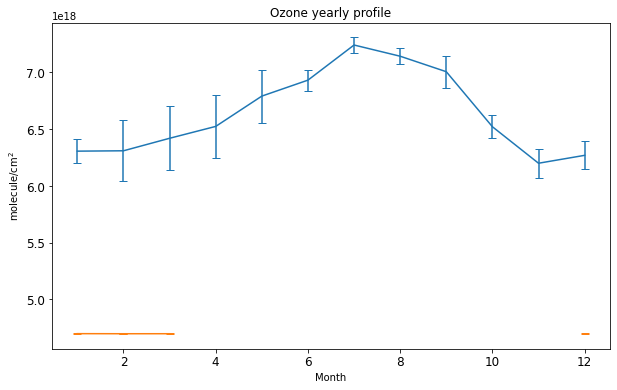

In [36]:
## simple plotting with error
ax = tslocmeanmt.plot(figsize=(10,6),title='Ozone yearly profile',ylabel='molecule/cm$^2$',yerr=tslocstdmt,capsize=4,fontsize=12)
tsmerramm2.plot(figsize=(10,6),xlabel='Month',yerr=tsmerrastdmt,capsize=4,fontsize=12)

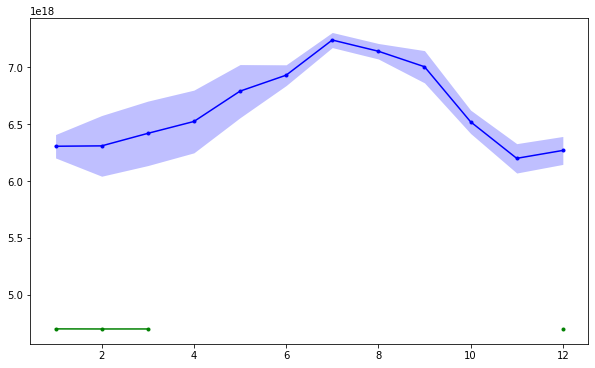

In [42]:
##pyplot plotting
x = tslocmeanmt.index
y1 = tslocmeanmt
err1 = tslocstdmt
y2 = tsmerramm2
err2 = tsmerrastdmt
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1 = plt.plot(x, y1, '.-b')
ax1 = plt.fill_between(x, y1-err1, y1+err1,alpha=.25, edgecolor='#3F7F4C', facecolor='b',linewidth=0)
#ax2 = ax1.twinx()
ax2 = plt.plot(x, y2, '.-g')
#ax2 = plt.fill_between(x, y2-err2, y1+err2,alpha=.25, edgecolor='#3F7F4C', facecolor='g',linewidth=0)

In [ ]:
################## TESTING AFTER THIS LINE

In [13]:
testdf = pd.read_csv(filename)
testdf.set_axis(['fixedP','fixedO3','modelP','modelO3'], axis=1, inplace=True)
tdfa = testdf[testdf['modelP'] <= 226.32].assign(modelP=((1.73-np.log(testdf.modelP/226.32))/0.000157))
tdfb = testdf[testdf['modelP'] > 226.32].assign(modelP=((1-(testdf.modelP/1013.25)**(1/5.25588))/2.25577e-5))
testdf2=tdfa.append(tdfb)
testdf2.set_axis(['fixedP','fixedO3','modelAlt','modelO3'], axis=1, inplace=True)
testdf2

,fixedP,fixedO3,modelAlt,modelO3
0,43.000000,4.843681e-06,23130.502659,6.716270e-06
1,47.000000,4.117874e-06,22031.489009,5.400142e-06
2,52.275398,3.047331e-06,20945.254799,4.008552e-06
3,58.243900,1.983698e-06,19871.799326,2.266292e-06
4,65.787903,9.266657e-07,18811.109829,8.210488e-07
5,73.103401,6.128906e-07,17763.195931,4.538676e-07
6,84.512299,3.621917e-07,16728.039474,2.518973e-07
7,98.665703,2.268939e-07,15692.932467,1.904148e-07
8,114.763000,1.750633e-07,14657.782636,1.448122e-07
9,134.837006,1.456470e-07,13622.703063,1.473533e-07


In [14]:
altdiff=testdf2.modelAlt.diff()
altdiff=altdiff.replace(altdiff[0],altdiff[1])
altdiff=-altdiff
altdiff

0     1099.013650
1     1099.013650
2     1086.234210
3     1073.455473
4     1060.689496
5     1047.913898
6     1035.156458
7     1035.107006
8     1035.149832
9     1035.079573
10    1035.110545
11     990.471107
12     944.784882
13     904.886671
14     884.167473
15     593.349728
16     548.550612
17     507.299151
18     474.893811
19     446.279962
20     423.325756
21     400.317431
22     383.488439
23     365.730670
24     235.368146
25     229.485687
26     223.953928
27     217.588642
28     212.727080
29     166.859236
30     123.033535
31     121.344553
32     119.726421
33     118.265900
34     116.845943
35     115.329847
36     113.836055
37     112.526833
38     111.256552
39     109.884456
40     108.669133
41     121.323690
Name: modelAlt, dtype: float64

In [20]:
tdfa = testdf2[testdf2['modelAlt'] <= 11000].assign(modelAlt=(15.04-0.00649*testdf2.modelAlt))
tdfb = testdf2[testdf2['modelAlt'] > 11000].assign(modelAlt=-56.46)
testdf3=tdfb.append(tdfa)
testdf3.set_axis(['fixedP','fixedO3','modelT','modelO3'], axis=1, inplace=True)
testdf3

,fixedP,fixedO3,modelT,modelO3
0,43.000000,4.843681e-06,-56.460000,6.716270e-06
1,47.000000,4.117874e-06,-56.460000,5.400142e-06
2,52.275398,3.047331e-06,-56.460000,4.008552e-06
3,58.243900,1.983698e-06,-56.460000,2.266292e-06
4,65.787903,9.266657e-07,-56.460000,8.210488e-07
5,73.103401,6.128906e-07,-56.460000,4.538676e-07
6,84.512299,3.621917e-07,-56.460000,2.518973e-07
7,98.665703,2.268939e-07,-56.460000,1.904148e-07
8,114.763000,1.750633e-07,-56.460000,1.448122e-07
9,134.837006,1.456470e-07,-56.460000,1.473533e-07


In [24]:
nair = testdf.modelP*100*6.022e23/(8.314463*(testdf3.modelT+273.15))
testdf4 = testdf2.assign(modelO3=testdf3.modelO3*nair)
testdf4

,fixedP,fixedO3,modelAlt,modelO3
0,43.000000,4.843681e-06,23130.502659,7.587743e+18
1,47.000000,4.117874e-06,22031.489009,7.249784e+18
2,52.275398,3.047331e-06,20945.254799,6.382215e+18
3,58.243900,1.983698e-06,19871.799326,4.270636e+18
4,65.787903,9.266657e-07,18811.109829,1.827544e+18
5,73.103401,6.128906e-07,17763.195931,1.190911e+18
6,84.512299,3.621917e-07,16728.039474,7.775978e+17
7,98.665703,2.268939e-07,15692.932467,6.915287e+17
8,114.763000,1.750633e-07,14657.782636,6.187220e+17
9,134.837006,1.456470e-07,13622.703063,7.406727e+17


In [16]:
testdf4 = testdf2.assign(modelO3=(testdf3.modelO3*2.69e25))
testdf4

,fixedP,fixedO3,modelAlt,modelO3
0,43.000000,4.843681e-06,23130.502659,1.806677e+20
1,47.000000,4.117874e-06,22031.489009,1.452638e+20
2,52.275398,3.047331e-06,20945.254799,1.078300e+20
3,58.243900,1.983698e-06,19871.799326,6.096325e+19
4,65.787903,9.266657e-07,18811.109829,2.208621e+19
5,73.103401,6.128906e-07,17763.195931,1.220904e+19
6,84.512299,3.621917e-07,16728.039474,6.776037e+18
7,98.665703,2.268939e-07,15692.932467,5.122158e+18
8,114.763000,1.750633e-07,14657.782636,3.895448e+18
9,134.837006,1.456470e-07,13622.703063,3.963804e+18


In [31]:
(testdf4.modelO3*(altdiff/(testdf4.modelAlt[0]-testdf4.modelAlt[41]))).sum()*(testdf4.modelAlt[0]-testdf4.modelAlt[41])/10000

4.695388368359023e+18

In [32]:
(testdf4.modelO3*altdiff).sum()/10000

4.695388368359023e+18

In [37]:
merradf

,date,ozone
0,2012-12-01 00:00:00,4.698226e+18
1,2012-12-01 03:00:00,4.700610e+18
2,2012-12-01 06:00:00,4.700953e+18
3,2012-12-01 09:00:00,4.700617e+18
4,2012-12-01 12:00:00,4.700779e+18
...,...,...
6779,2019-03-31 09:00:00,4.696085e+18
6780,2019-03-31 12:00:00,4.697027e+18
6781,2019-03-31 15:00:00,4.698883e+18
6782,2019-03-31 18:00:00,4.698227e+18


In [39]:
merradf2

,date,ozone
0,2012-12-01 00:00:00,0.000021
1,2012-12-01 03:00:00,0.000021
2,2012-12-01 06:00:00,0.000022
3,2012-12-01 09:00:00,0.000022
4,2012-12-01 12:00:00,0.000022
...,...,...
6779,2019-03-31 09:00:00,0.000023
6780,2019-03-31 12:00:00,0.000023
6781,2019-03-31 15:00:00,0.000024
6782,2019-03-31 18:00:00,0.000023


In [40]:
tsmerraa = merradf2.set_index('date')
tsmerrameanmta = tsmerraa.ozone.groupby(tsmerraa.index.month).mean()
tsmerramma = tsmerraa.ozone.resample('M').mean()
tsmerramm2a = tsmerramma.groupby(tsmerramma.index.month).mean()
tsmerrastdmta = tsmerraa.ozone.groupby(tsmerraa.index.month).std()
tsmerrastdmta

date
1     0.000002
2     0.000002
3     0.000002
12    0.000001
Name: ozone, dtype: float64

In [41]:
tsmerramm2a

date
1     0.000022
2     0.000022
3     0.000023
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10         NaN
11         NaN
12    0.000021
Name: ozone, dtype: float64